# Example case for causal inference in ecommerce pricing
Lars Roemheld, 2021. http://mdl.fit/

This example notebook gives a real-life example of causal inference in the wild. We use real ecommerce sales data to infer causal effects of price on quantity sold ("price elasticity of demand"). A follow up will move into heterogeneous treatment effects ("product-specific elasticity"). See the accompanying blogpost [TODO] for an easier-to-read version.

The notebook originally accompanies a workshop on causal inference for Machine Learners. Reach out if you are interested to learn more.

In [1]:
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

# Sample ecommerce dataset 
For this example, I'll use a public domain (CC0 1.0 Universal) dataset, sourced from https://www.kaggle.com/vijayuv/onlineretail . Judging from artifacts in the data, this is likely original data from Dotcomgiftshop (a real FBA reseller, now also branding under https://www.rexlondon.com/ ).

Note that the data is cleaned and improved in the separate `data_prep` notebook. Here, I'll just load the prepared dataset.

**NB: This data has one _significant_ technical limitation: we only observe sales, not stock-days. That means we have no data at all about prices on days where 0 sales occured. Since typically a majority of stock units are rarely sold, this is a big issue - but one we're choosing to ignore for this example.** Note that because we have no information about stock-outs and product introductions, we can *not* assume 0 sales for "missing" product-date-combinations - and worse, if we did, we wouldn't have any valid information on price.

Throughout this notebook, we sometimes use `SKU` to mean stock-keeping-unit, i.e. `StockCode` in this dataset or "item"/"product".

In [2]:
df = pd.read_parquet('ecom_sample_clean.parquet')

## Quick visualization for plausibility checks
Shop seems to have been closed for christmas 2010...

In [3]:
df.set_index(['Date', 'StockCode', 'Country']).sample(10)

,,,Description,Quantity,revenue,UnitPrice
Date,StockCode,Country,,,,
2011-11-08,23215,United Kingdom,JINGLE BELL HEART ANTIQUE SILVER,109,198.88,1.824587
2011-08-22,22356,United Kingdom,CHARLOTTE BAG PINK POLKADOT,20,17.00,0.850000
2011-11-22,21408,United Kingdom,SPOTTY PINK DUCK DOORSTOP,8,34.00,4.250000
2011-10-07,84997A,United Kingdom,GREEN 3 PIECE POLKADOT CUTLERY SET,6,24.90,4.150000
2011-10-27,21577,France,SAVE THE PLANET COTTON TOTE BAG,6,13.50,2.250000
2011-06-12,21672,United Kingdom,WHITE SPOT RED CERAMIC DRAWER KNOB,18,22.50,1.250000
2011-03-31,37370,United Kingdom,RETRO COFFEE MUGS ASSORTED,12,15.00,1.250000
2011-01-18,82486,United Kingdom,WOOD S/3 CABINET ANT WHITE FINISH,24,166.80,6.950000
2011-04-19,21680,United Kingdom,WOODLAND STICKERS,1,1.63,1.630000


<AxesSubplot:title={'center':'number of items sold and revenue over time'}, xlabel='Date'>

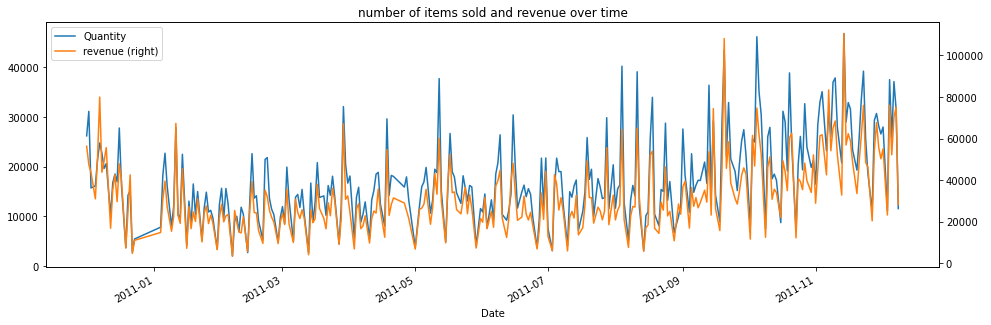

In [4]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and revenue over time', 
    secondary_y='revenue',
    figsize=(16, 5)
)

## Variance of prices per product?
For identification of elasticity, we need variation in prices within products - otherwise we can never disambiguate price-responses from product preferences.

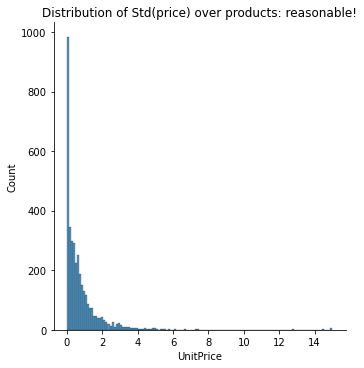

In [5]:
sns.displot(df.groupby('StockCode').UnitPrice.std().dropna().clip(0, 15), kde=False)
plt.title('Distribution of Std(price) over products: reasonable!');

In [6]:
len(df)

298222

In [7]:
df_mdl = df[
    (df.groupby('StockCode').UnitPrice.transform('std') > 0)
]
del df

In [8]:
len(df_mdl)

294575

## Background: price elasticity of demand
"It is a known fact" of economics that price elasticities exist ("analyst inductive bias/prior"). Elasticity is basically a fancy way to say "derivative of demanded quantity with respect to price". But there's a twist: elasticity is *relative* derivatives:

$$e = \frac{dQ / Q}{dP / P}$$

This is not just economists being fancy. Empirically, it is often a decent heuristic that $e$ is constant in $p$ - which the derivates itself are not. In other words, demand can be (locally) approximated to be an exponential function in p:

$$ q(p) = \text{const} * p ^ e $$

Knowing this functional form makes our lives much easier later. Note that we can take

$$ 
\begin{aligned}\log q(p) & =\log\left(\text{const}*p^{e}\right)\\
 & =\log(\text{const})+e\log(p)
\end{aligned}
$$

In other words, in log-log-space elasticity is just the coefficient of linear regression.

Since we can only learn from within-product price variation, we can discard all observations that do not contain information, i.e. where we do not see purchases at multiple different prices

In [9]:
df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

<a id="naive"></a>
## Do the naive analysis first
Let's confuse correlation & causation! In this example, price seems weakly negatively correlated with demand (the next chapter explains the purpose of $\log$-ing variables). 

Since the regression coefficient is $cov(p, q) / var(p)$, this naive calculation would yield elasticity of around $e = \frac{-0.52}{0.90} = -0.6$.

The following real analysis will show that this significantly underestimates the causal effect (i.e. we will under-estimate the demand drop that is expected when raising prices).

In [10]:
df_mdl[['LnP', 'LnQ']].cov()

,LnP,LnQ
LnP,0.90431,-0.526940
LnQ,-0.52694,1.816541


## Now for the real analysis: price elasticity of demand

In [11]:
import statsmodels.api as sm # get full stats on regressions

def binned_ols(df, x, y, n_bins, plot=True, plot_title='', plot_ax=None, **plt_kwargs):
    # A visual form of de-noising: bin explanatory variable first, 
    # then take means-per-bin of variable to be explaioned, then
    # regress/plot 
    x_bin = x + '_bin'
    df[x_bin] = pd.qcut(df[x], n_bins)

    tmp = df.groupby(x_bin).agg({
        x: 'mean',
        y: 'mean'
    })

    if plot:
        tmp.plot(
            x=x, 
            y=y,
            figsize=(18, 6),
            title=plot_title,
            ax=plot_ax,
            **plt_kwargs
        )
    
    del df[x_bin]
    mdl = sm.OLS(tmp[y], sm.add_constant(tmp[x]))
    res = mdl.fit()
    return res

"Naive" elasticity estimated to be -0.60642262949329


/Users/lars/anaconda3/envs/ex_causalinf_env/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LnQ   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     50.31
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           8.13e-06
Time:                        14:57:52   Log-Likelihood:                -2.4962
No. Observations:                  15   AIC:                             8.992
Df Residuals:                      13   BIC:                             10.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3614      0.102     23.070      0.000       2.140       2.583
LnP           -0.6064      0.085     -7.093      0.000      -0.791      -0.422
==============================================================================
Omnibus:                        6.769   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                3.768
Skew:                           0.710   Prob(JB):                        0.152
Kurtosis:                       5.002   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

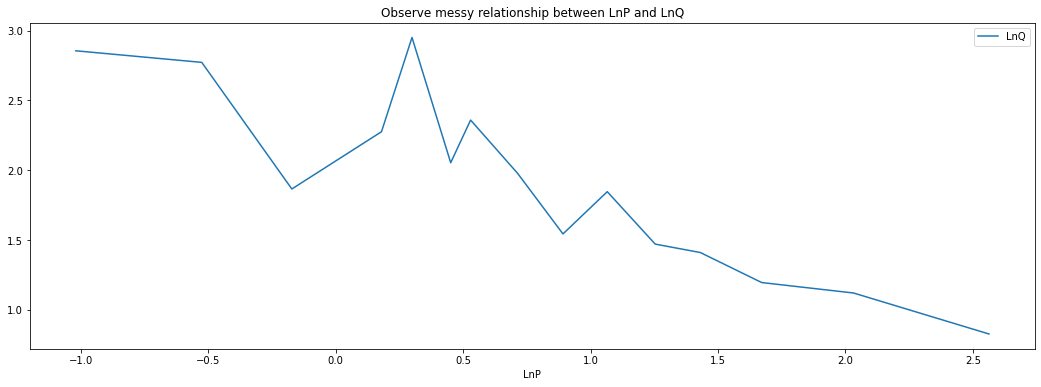

In [12]:
ols_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
    plot_title='Observe messy relationship between LnP and LnQ'
)

print(f'"Naive" elasticity estimated to be {ols_fit.params["LnP"]}')
ols_fit.summary()

## Build standard econometrics-style causal model
There is a subtle point here about regularization: the full model matrix (see below) has a lot of collinearity, so there is no unique solution to OLS. Given the number of regressors, we wouldn't expect all of them to be relevant. Either argument leads us to regularizing the regression: either to yield a unique solution, or to encode our prior, or both.

But since we are interested in elasticity, i.e. the regression coefficient of LnP, we shouldn't regularize that particular feature! The larger our regularization-$\alpha$, the smaller the coefficient of interest would be. Unfortunately, most libraries don't allow removing features from penalization. So instead, I wiggled $\alpha$ and manually verified that scaling LnP doesn't change its coefficient (multiplying LnP by 10 multiplies the optimal coefficient by 0.1, reducing penalty).

Under ideal conditions (lots of obs where $q=0$), we would prefer ZINB loss (negative binomial deals with overdispersion, zero-inflation with long-tail of products). To keep things simple, let's go with Poisson. 

To show that the distributional assumption has a large effect, we are also fitting OLS (i.e. Gaussian loss, or MSE).

In [13]:
import sklearn.preprocessing

In [14]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer


In [15]:
feature_generator_basic = ColumnTransformer(
    [
        ('StockCode', OneHotEncoder(), ['StockCode']),
        ('Date', OneHotEncoder(), ['Date']),
        ('Country', OneHotEncoder(), ['Country']),
        ('LnP', 'passthrough', ['LnP']),
    ], remainder='drop'
)

mdl_basic = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.PoissonRegressor(
        alpha=1e-6,  # l2 penalty strength; manually selected value for minimum interference on LnP-coef (elasticity)
        fit_intercept=False, # no need, since we have OneHot encodings without drop
        max_iter=100_000, 
    )),
], verbose=True)

mdl_basic_ols = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.Ridge(
        alpha=1e-20,  # l2 penalty strength, "very small"
        fit_intercept=False, 
        max_iter=100_000, 
    )),
], verbose=True)

In [16]:
mdl_basic.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['Quantity'] # Poisson regression has log-link, so LnQ is implicit in loss function
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing reg, total= 2.0min


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 PoissonRegressor(alpha=1e-06, fit_intercept=False,
                                  max_iter=100000))],
         verbose=True)

In [17]:
mdl_basic_ols.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['LnQ'] # log-normal
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.5s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-20, fit_intercept=False, max_iter=100000))],
         verbose=True)

In [18]:
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):')
coef = pd.DataFrame({
    'feat': mdl_basic['feat_proc'].get_feature_names(),
    'coef': mdl_basic['reg'].coef_
})
coef.iloc[-1]

"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):


feat         LnP
coef   -2.875894
Name: 3708, dtype: object

In [19]:
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):')
pd.DataFrame({
    'feat': mdl_basic_ols['feat_proc'].get_feature_names(),
    'coef': mdl_basic_ols['reg'].coef_
}).iloc[-1]

"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):


feat        LnP
coef   -1.77085
Name: 3708, dtype: object

Ouch. This large difference between Poisson and log-normal estimates is bad news for the DML approach to follow: **in a real-life example, we should use DML within a Poisson regression, not log-normal**. But for illustrative purposes, let's press on.

/Users/lars/anaconda3/envs/ex_causalinf_env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lars/anaconda3/envs/ex_causalinf_env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


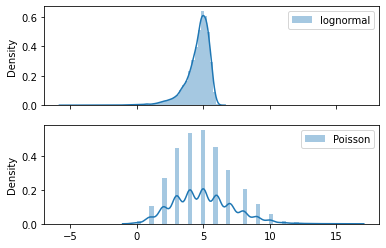

In [20]:
# The significant difference in estimates for log-normal vs. Poisson
# is explained by Poisson's fat tails: noisy/extreme values have a stronger
# effect in log-normal than in Poisson.
f, ax = plt.subplots(2, 1, sharex=True)
pos_normal = np.random.normal(loc=100, scale=100, size=12_000)
pos_normal = pos_normal[pos_normal > 0]
sns.distplot(np.log(pos_normal), label='lognormal', ax=ax[0])
sns.distplot(np.random.poisson(lam=5, size=10_000), label='Poisson', ax=ax[1])

ax[0].legend()
ax[1].legend()

<AxesSubplot:title={'center':'Date fixed effects track (avg) sales, but not perfectly: Deviation is explained by large effect of individual items [unit-normalized data]'}, xlabel='Date'>

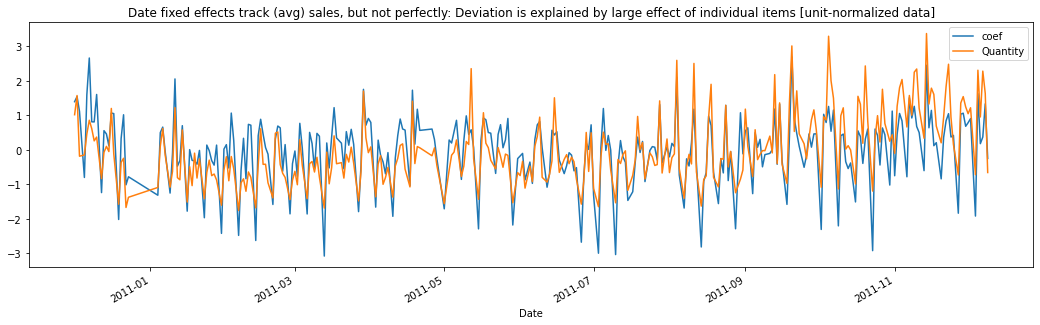

In [21]:
# For some intuition about this regression, convince ourselves that
# the time fixed effects do inded track quantity sold over time
# The divergence of q and time-coefs at the beginning and end likely 
# points towards new products that are introduced/old ones that are faded out
(
    pd.concat(
        [
            coef[coef.feat.str.startswith('Date')].reset_index(drop=True),
            df_mdl.groupby('Date').Quantity.sum().reset_index()
        ], 
        axis=1
    )
    .set_index(['Date'])
    .drop(columns=['feat'])
    .pipe(
        lambda d: (d - d.mean()) / d.std()
    )
).plot(
    figsize=(18, 5),
    title='Date fixed effects track (avg) sales, but not perfectly: Deviation is explained by large effect of individual items [unit-normalized data]'
)

# DML Tree by hand
Now let's do some fancier causal modelling. `econml` is a cool new library that promises to automate a lot of this (and other techniques) in the future. As of early 2021, I've found the API to be too unstable, but this will hopefully change as it's under active development.

For Double ML we want to orthogonalize outcome $Y$ and treatment $T$, given covariates $X, W$ ($X$ being dimensions that treatment effect might vary over and $W$ being nuisance control variables). Let
$$\tilde{Y}=Y-E[Y|X,W]$$
and
$$\tilde{T}=T-E[T|X,W]$$

Where estimates of expectations are fit using nonparametrics (i.e. RandomForests). 

Since we are using vanilla RandomForest, we are optimizing mean-squared-error (mse). Ideally, we would want Poisson/ZINB loss for $Y$ (quantity). Vanilla RandomForest doesn't support non-normal loss, and for this example I want to avoid more finicky options like lightGBM. So in the absence of built-in Poisson loss, we will fit mse on $\log(q)$ (i.e. log-normal loss). This also simplifies treatment effect estimation, because 
$$\hat\theta = \frac{dLnQ}{dLnP} = \frac{\log(q)-\log(\bar q)}{\log(p)-\log(\bar p)}$$

where $\bar p$ and $\bar q$ are average price and quantity for each item, respectively.

Following "Double Machine Learning", $\tilde{Y}$ and $\tilde{T}$ are orthogonal after residualization, so we can infer (linear) effects by directly regressing 
$\tilde{Y} = \hat{\theta}\tilde{T}$,
or in our case here, 
$$\hat{\theta} = \frac{\tilde{dLnQ}}{\tilde{dLnP}}$$.

Then we can build an additional model ("Causal Forests") to find a function yielding treatment effects that are heterogeneous in relevant features $X$, $\hat{\theta}(X)$
$$\hat\theta(X) = \arg \min_{\theta} E_n [(\tilde{Y} - \theta(X) \cdot \tilde{T} )^2]$$

That is, in our case,
$$\theta(X) = \arg \min_{\theta} E_n [(\frac{\tilde{Q}}{\tilde{P}} - \theta(X))^2]$$

To properly do DML, we should sample-split: use different data samples for fitting the auxiliary models ($\tilde{T}, \tilde{Y}$), and for fitting the inferential model. To show the concept, we are double dipping here at first, and implement a full sample split below.

## Step 0: delta-log-scale & feature engineering
Effectively, we are adding the prior of item-level effects to our preprocessing: Instead of just taking logs, we already *de-mean the data on item level*, effectively taking out variation over products. Note that this is equivalent to adding an item-level fixed effect to a regression model.

$$
\text{dLnP}_{i,t} = \log(p_{i,t}) - \log(\bar{p_i})
$$

and conversely for quantity.

Implemented features 
- Month, DoW, DoM
- something bag-of-word-y to recover SKU categories/taxonomy
- stock age (for trends)
- SKU price level ("expensiveness", independent of within-SKU price variation)

_feasible but deprioritized features_
- return customer
- SKUs that tend to be only item in order vs. add-on items
- graph clustering on orders to recover complements


In [22]:
# Note that de-meaning happens on StockCode-level here!
df_mdl['dLnP'] = np.log(df_mdl.UnitPrice) - np.log(df_mdl.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl.Quantity) - np.log(df_mdl.groupby('StockCode').Quantity.transform('mean')) 

Note that our item-level de-meaning already effectively controls for StockCode-level effects, yielding naive average elasticity of around $e = \frac{-0.12}{0.07} = -1.7$.

In [23]:
df_mdl[['dLnP', 'dLnQ']].cov()

,dLnP,dLnQ
dLnP,0.069442,-0.122739
dLnQ,-0.122739,1.274948


In [24]:
df_mdl = df_mdl.assign(
    month = lambda d: d.Date.dt.month,
    DoM =   lambda d: d.Date.dt.day,
    DoW =   lambda d: d.Date.dt.weekday,
    stock_age_days = lambda d: 
        (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    sku_avg_p = lambda d: 
        d.groupby('StockCode').UnitPrice.transform('median')
)

## Step 1: auxiliary models to orthogonalize T (price) and Y (quantity)
Note that since we're using RandomForests, we should be a little careful about features: one-hot encoded (SKU, date, country) in principle allows the trees to fully overfit each observation (we summarized the data to that level above). As a simple workaround, and since we are using `dLnP`/`dLnQ` anyway, we are just removing StockCode from the features - SKU fixed effects have already been removed by construction.

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
feature_generator_full = ColumnTransformer(
    [
        # do NOT include to reduce overfit (price is sku-level-demeaned anyway): 
        # ('StockCode', OneHotEncoder(), ['StockCode']), 
        ('Date', OneHotEncoder(), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p']),
    ], remainder='drop'
)

In [27]:
model_y = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_y', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0)) 
    # n_samples_leaf/n_estimators is set to reduce model (file) size and runtime
    # larger models yield prettier plots.
])
model_t = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_t', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0))
])


In [28]:
import joblib

try: # load existing models, if possible
    model_y = joblib.load('models/step1_model_y.joblib')
    model_t = joblib.load('models/step1_model_t.joblib')
except:
    print('No pre-existing models found, fitting aux models for y and t')
    model_y.fit(df_mdl, df_mdl.dLnQ)
    model_t.fit(df_mdl, df_mdl.dLnP)
    
    joblib.dump(model_y, 'models/step1_model_y.joblib', compress=True)
    joblib.dump(model_t, 'models/step1_model_t.joblib', compress=True)

In [29]:
# Get first-step, predictions to residualize ("orthogonalize") with (in-sample for now)
q_hat = model_y.predict(df_mdl)
p_hat = model_t.predict(df_mdl)

In [30]:
df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)

"Average" elasticity estimated using DML to be -1.821
Note that this is close to our econometric contols - some difference comes from the different distribution assumptions (Poisson vs. log-normal)


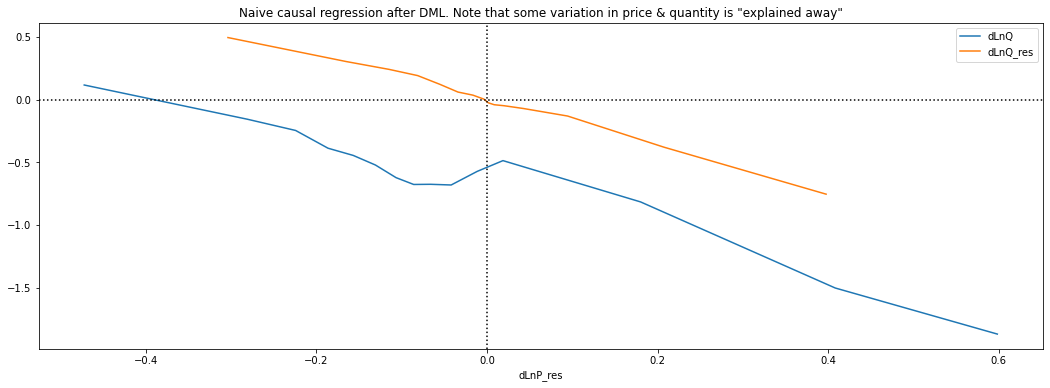

In [31]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Naive causal regression after DML. Note that some variation in price & quantity is "explained away"',
    plot_ax=plt.gca()
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

"Average" elasticity estimated using DML (now supposedly valid estimate!) to be -1.821
Note that this is close to our econometric contols - some difference comes from the different distribution assumptions (Poisson vs. log-normal)


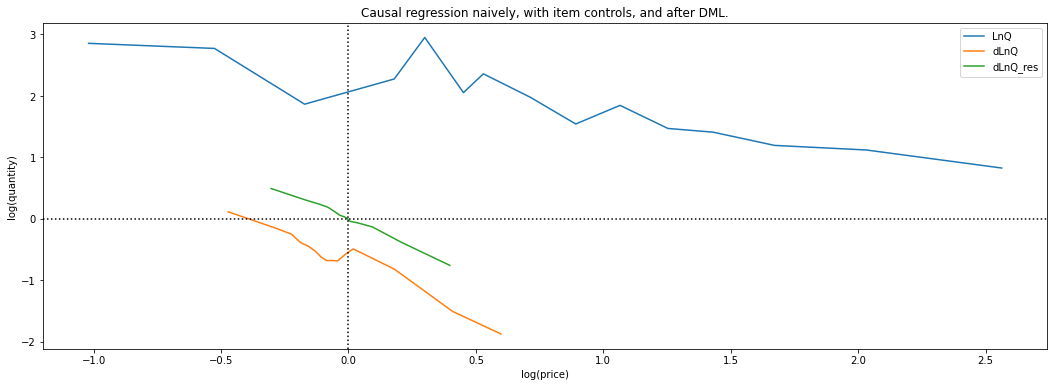

In [32]:
old_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Causal regression naively, with item controls, and after DML.',
    plot_ax=plt.gca()
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML (now supposedly valid estimate!) to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

In [33]:
def get_feat_generator_names(gen):
    # workaround to sklearn native .get_feature_names() failing
    # because StandardScaler strangely doesn't implement it
    res = []
    for i, (k, t) in enumerate(gen.named_transformers_.items()):
        if k == 'remainder':
            continue
        try: 
            res += [f'{k}_{n}' for n in t.get_feature_names()]
        except:
            res += list(gen.transformers_[i][2])
    return res

<AxesSubplot:title={'center':'feature importances for DML estimators of treatment(p) and outcome(q)'}, ylabel='feat'>

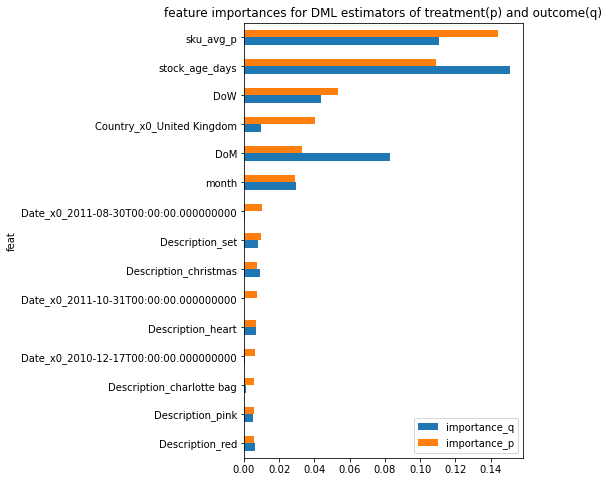

In [34]:
feat_imp = pd.DataFrame({
    'feat': get_feat_generator_names(model_y['feat_proc']),
    'importance_q': model_y['model_y'].feature_importances_,
    'importance_p': model_t['model_t'].feature_importances_,
}).set_index('feat')

feat_imp.sort_values(
    by='importance_p'
).iloc[-15:].plot.barh(
    figsize=(5, 8), 
    title='feature importances for DML estimators of treatment(p) and outcome(q)'
)

## Step 2: Inferential model for causal elasticity
Now, the inferential model is trying to predict $\hat\theta = \frac{dLnQ_{res}}{dLnP_{res}}$. After residualizing, `dLnP_res` is often *very* small. These values blow up our estimator - so to reduce noisiness, we are dropping all observations with very small residual price variation. Arguably, they don't contain much information anyway, because there is so little price variation left.

There is one more technicality in DML: Chernozhukov proposes using a slightly different estimator of treatment effect than standard OLS for robustness reasons. Instead of taking the standard OLS-solution, $ \hat\theta = (\tilde P'\tilde P)^{-1}\tilde P' \tilde Q $, Chernozhukov uses the following, de-biased estimator. Note that the first $P$ is residualized, while the second is *not*, and the third is.

$$ \hat\theta = (\tilde P' P)^{-1} \tilde P' \tilde Q $$

This estimator is fit 2-fold, once on either half of the data (the other half being used for the auxiliary models). The average between both fits is an efficient estimator. Below, DML is implemented "properly": with sample splitting, and debiased estimator.

In [35]:
from sklearn.model_selection import KFold

fitting model_y
fitting model_t
DML elast:  -1.897013259744641
OLS elasticity for comparison: -1.8496380336400018
fitting model_y
fitting model_t
DML elast:  -1.863765883590684
OLS elasticity for comparison: -1.8163612481849076
DML efficient estimate of elasticity: -1.8803895716676626


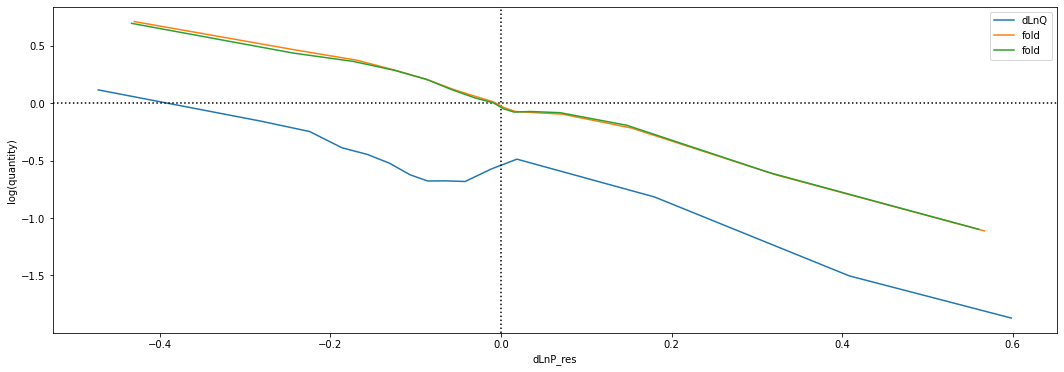

In [43]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)
plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


elast_estimates = list()
for idx_aux, idx_inf in KFold(
    n_splits=2, shuffle=True).split(df_mdl):
    
    df_aux = df_mdl.iloc[idx_aux]
    df_inf = df_mdl.iloc[idx_inf].copy()
    
    # step 1: aux models and residualize in inferential set
    print('fitting model_y')
    model_y.fit(df_aux, df_aux.dLnQ)
    print('fitting model_t')
    model_t.fit(df_aux, df_aux.dLnP)
    
    df_inf = df_inf.assign(
        dLnP_res = df_inf['dLnP'] - model_t.predict(df_inf),
        dLnQ_res = df_inf['dLnQ'] - model_y.predict(df_inf),
    )
    
    binned_ols(
        df_inf,
        x='dLnP_res',
        y='dLnQ_res',
        n_bins=15,
        plot_ax=plt.gca(),
        label='fold'
    )

    
    # ignore observations where we residualized away all variation in price
    mask = (~(df_inf.dLnP_res.abs() < 0.01))
    df_inf_censored = df_inf[mask]
    
    # step 2.1: Chernozhukov DML inference
    elast = (
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP'])
        # the last part here deviates from standard OLS solution
    )
    
    print('DML elast: ', elast)
    elast_estimates.append(elast)

    print('OLS elasticity for comparison:',
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP_res'])
    )    

    elast_estimates.append(elast)

print("DML efficient estimate of elasticity:", np.mean(elast_estimates))